<a href="https://colab.research.google.com/github/stellagerantoni/LatentCfMultivariate/blob/main/multivariate_pendigits(cl_and_auto_trained_on_all).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/stellagerantoni/LatentCfMultivariate

In [ ]:
!pip install -q wildboar
!pip install -q scikit-learn
!pip install -q stumpy
!pip install -q fastdtw
!pip install aeon[all_extras]

In [3]:
import logging
import os
import warnings
from argparse import ArgumentParser
from aeon.datasets import load_classification

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.spatial import distance_matrix
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from wildboar.datasets import load_dataset
from wildboar.ensemble import ShapeletForestClassifier
from wildboar.explain.counterfactual import counterfactuals
%cd '/content/LatentCfMultivariate'
from _guided import ModifiedLatentCF
from help_functions import *
from keras_models import *

/content/LatentCfMultivariate


In [4]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
RANDOM_STATE = 39

# **ACTUALL CODE**

In [188]:
RANDOM_STATE = 39
X, y, data_information = load_classification('PenDigits')
print(f'shape of X = {X.shape}')
print(f'shape of y = {y.shape}')
print(f'data imformation = {data_information}')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print(f'shape of X train = {X_train.shape}')
print(f'shape of y train = {y_train.shape}')

shape of X = (10992, 2, 8)
shape of y = (10992,)
data imformation = {'problemname': 'pendigits', 'timestamps': False, 'missing': False, 'univariate': False, 'equallength': True, 'classlabel': True, 'targetlabel': False, 'class_values': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']}
shape of X train = (8793, 2, 8)
shape of y train = (8793,)


In [189]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

In [190]:
# Upsample the minority class
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f'before: {class_counts}')
X_train,y_train = upsample_minority_multivariate(X_train,y_train)
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f'after: {class_counts}')

before: [914 914 915 844 915 844 845 914 844 844]
after: [915 915 915 915 915 915 915 915 915 915]


In [191]:
X_train = X_train.transpose (0,2,1)
X_test = X_test.transpose(0,2,1)
n_training,n_timesteps, n_features= X_train.shape

X_train_processed, trained_scaler =  normalize_multivariate(data=X_train, n_timesteps=n_timesteps, n_features = n_features)
X_test_processed, _ =  normalize_multivariate(data=X_test, n_timesteps=n_timesteps, scaler=trained_scaler, n_features = n_features)

X_train_processed_padded, padding_size = conditional_pad_multivariate(X_train_processed) # add extra padding zeros if n_timesteps cannot be divided by 4, required for 1dCNN autoencoder structure
X_test_processed_padded, _ = conditional_pad_multivariate(X_test_processed)

n_timesteps_padded = X_train_processed_padded.shape[1]
print(f"Data pre-processed, original #timesteps={n_timesteps}, padded #timesteps={n_timesteps_padded}.")

#check the processing (0,1) min should be min 0 and max should be max 1
print(f"\nmin value = {np.min(X_train)}, max value = {np.max(X_train)}")
print(f"min value normalized = {np.min(X_train_processed)}, max value normalized= {np.max(X_train_processed)}")

#check that padding paddes the right dimention
print(f"\nX_train.shape = {X_train.shape}" )
print(f"X_train_processed_padded.shape = {X_train_processed_padded.shape}")


Data pre-processed, original #timesteps=8, padded #timesteps=8.

min value = 0.0, max value = 100.0
min value normalized = 0.0, max value normalized= 1.0

X_train.shape = (9150, 8, 2)
X_train_processed_padded.shape = (9150, 8, 2)


In [192]:
from sklearn.model_selection import train_test_split
X_train_c, X_validation_c, y_train_c, y_validation_c = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train)


In [193]:
print(f'X_train = {X_train.shape}')
print(f'X_validation = {X_validation_c.shape}')
print(f'X_test = {X_test.shape}')

y_train_classes = y_train_c
y_validation_classes = y_validation_c
y_test_classes = y_test

from tensorflow.keras.utils import to_categorical
y_train_c = to_categorical(y_train, len(np.unique(y_train)))
y_validation_c = to_categorical(y_validation_c, len(np.unique(y_validation_c)))
y_test_c = to_categorical(y_test, len(np.unique(y_test)))

print(f'\ny_train_classes = {y_train_classes.shape}, y_validation_classes = {y_validation_classes.shape}, y_test_classes = {y_test_classes.shape}')
print(f'y_train = {y_train_c.shape}, y_validation = {y_validation_c.shape}, y_test= {y_test.shape}')

X_train = (9150, 8, 2)
X_validation = (1830, 8, 2)
X_test = (2199, 8, 2)

y_train_classes = (7320,), y_validation_classes = (1830,), y_test_classes = (2199,)
y_train = (9150, 10), y_validation = (1830, 10), y_test= (2199,)


In [115]:


# ## 2. LatentCF models
# reset seeds for numpy, tensorflow, python random package and python environment seed
reset_seeds()
###############################################
# ### 1dCNN classifier

cnnClassifier = Classifier(
    n_timesteps_padded, n_features, n_output=10, add_dense_layer = False
)

optimizer = keras.optimizers.Adam(lr=0.001)
cnnClassifier.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

# Define the early stopping criteria
early_stopping_accuracy = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=15, restore_best_weights=True
)
# Train the model
reset_seeds()
print("Training log for LSTM-FCN classifier:")
classifier_history = cnnClassifier.fit(
    X_train,
    y_train,
    epochs=150,
    batch_size=12,
    shuffle=True,
    verbose=True,
    validation_data=(X_validation, y_validation),
    callbacks=[early_stopping_accuracy],
)

y_pred = cnnClassifier.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = balanced_accuracy_score(y_true=y_test_classes, y_pred=y_pred_classes)
print(f"LSTM-FCN classifier trained, with validation accuracy {acc}.")

Training log for LSTM-FCN classifier:
Epoch 1/150
610/610 [==============================] - 8s 8ms/step - loss: 0.2325 - accuracy: 0.8167 - val_loss: 0.1486 - val_accuracy: 0.8885
Epoch 2/150
610/610 [==============================] - 5s 8ms/step - loss: 0.1287 - accuracy: 0.9146 - val_loss: 0.1224 - val_accuracy: 0.9137
Epoch 3/150
610/610 [==============================] - 4s 6ms/step - loss: 0.1093 - accuracy: 0.9316 - val_loss: 0.1029 - val_accuracy: 0.9339
Epoch 4/150
610/610 [==============================] - 3s 5ms/step - loss: 0.0974 - accuracy: 0.9463 - val_loss: 0.0938 - val_accuracy: 0.9557
Epoch 5/150
610/610 [==============================] - 3s 5ms/step - loss: 0.0890 - accuracy: 0.9505 - val_loss: 0.0863 - val_accuracy: 0.9470
Epoch 6/150
610/610 [==============================] - 4s 6ms/step - loss: 0.0825 - accuracy: 0.9533 - val_loss: 0.0806 - val_accuracy: 0.9645
Epoch 7/150
610/610 [==============================] - 5s 8ms/step - loss: 0.0766 - accuracy: 0.9617 - v

ValueError: ignored

In [142]:
reset_seeds()


# ### 1dCNN autoencoder
autoencoder = Autoencoder( n_timesteps_padded,n_features,64)
optimizer = keras.optimizers.Adam(lr=0.0005)
autoencoder.compile(optimizer=optimizer, loss="mse")

# Define the early stopping criteria
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
# Train the model
reset_seeds()
print("Training log for 1dCNN autoencoder:")
autoencoder_history = autoencoder.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=12,
    shuffle=True,
    verbose=2,
    validation_data=(X_validation, X_validation),
    callbacks=[early_stopping])

ae_val_loss = np.min(autoencoder_history.history['val_loss'])
print(f"1dCNN autoencoder trained, with validation loss: {ae_val_loss}.")


(None, 8, 2)
(None, 8, 64)
(None, 4, 64)
(None, 4, 32)
(None, 2, 32)
(None, 2, 32)
(None, 4, 32)
(None, 4, 64)
(None, 8, 64)
(None, 8, 2)
Training log for 1dCNN autoencoder:
Epoch 1/50
610/610 - 7s - loss: 244.9960 - val_loss: 42.3420 - 7s/epoch - 12ms/step
Epoch 2/50
610/610 - 3s - loss: 31.1022 - val_loss: 24.3131 - 3s/epoch - 5ms/step
Epoch 3/50
610/610 - 3s - loss: 19.6727 - val_loss: 15.9629 - 3s/epoch - 5ms/step
Epoch 4/50
610/610 - 4s - loss: 14.6963 - val_loss: 14.3846 - 4s/epoch - 6ms/step
Epoch 5/50
610/610 - 5s - loss: 12.3006 - val_loss: 11.4344 - 5s/epoch - 8ms/step
Epoch 6/50
610/610 - 4s - loss: 10.9497 - val_loss: 10.0855 - 4s/epoch - 7ms/step
Epoch 7/50
610/610 - 3s - loss: 9.1189 - val_loss: 8.7160 - 3s/epoch - 5ms/step
Epoch 8/50
610/610 - 4s - loss: 8.1504 - val_loss: 8.5620 - 4s/epoch - 6ms/step
Epoch 9/50
610/610 - 3s - loss: 7.6528 - val_loss: 7.9406 - 3s/epoch - 5ms/step
Epoch 10/50
610/610 - 8s - loss: 6.6433 - val_loss: 6.9225 - 8s/epoch - 13ms/step
Epoch 11/5

1/1 [==============================] - 0s 51ms/step
y = [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


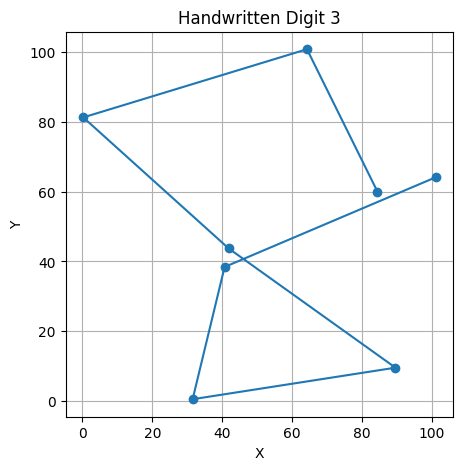

y = [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


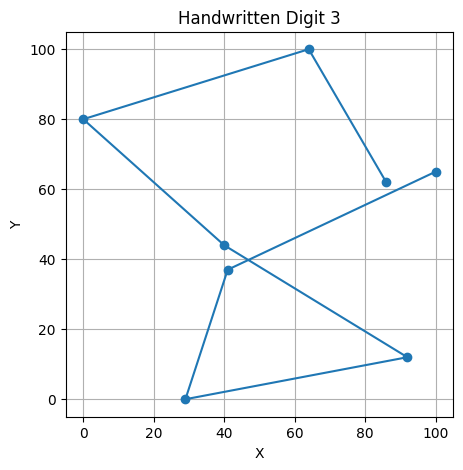

In [145]:
idx = 5
sample = X_test[idx:idx+1]
sample_label = y_test[idx:idx+1]
autoencoded_sample = autoencoder.predict(sample)
visualise_decoded_digit(autoencoded_sample,sample_label)
visualise_digit(X_test,y_test,idx)

In [ ]:
def extract_two_digits_new(X_train,y_train,X_test,y_test,n_1,n_2, RANDOM_STATE):
  zero_indices_train = np.where(y_train == n_1)[0]
  one_indices_train = np.where(y_train == n_2)[0]
  zero_indices_test = np.where(y_test == n_1)[0]
  one_indices_test = np.where(y_test == n_2)[0]

  X_train_zeroes = X_train[zero_indices_train]
  y_train_zeroes = y_train[zero_indices_train]

  X_train_ones = X_train[one_indices_train]
  y_train_ones = y_train[one_indices_train]

  X_test_zeroes = X_test[zero_indices_test]
  y_test_zeroes = y_test[zero_indices_test]

  X_test_ones = X_test[one_indices_test]
  y_test_ones = y_test[one_indices_test]

  X_train = np.concatenate([X_train_zeroes, X_train_ones])
  y_train = np.concatenate([y_train_zeroes, y_train_ones])
  X_test = np.concatenate([X_test_zeroes, X_test_ones])
  y_test = np.concatenate([y_test_zeroes, y_test_ones])

  X_train, y_train = shuffle(X_train, y_train, random_state=RANDOM_STATE)
  X_test, y_test = shuffle(X_test, y_test, random_state=RANDOM_STATE)

  print(f'Class 0 represents number {n_1}. [1.,0.]')
  print(f'Class 1 represents number {n_2}. [0.,1.]')

  return X_train, y_train, X_test, y_test

In [195]:
X_train_two, y_train_two, X_test_two, y_test_two= extract_two_digits_new(X_train_processed_padded,y_train,X_test_processed_padded,y_test,0,8,RANDOM_STATE)

Class 0 represents number 0. [1.,0.]
Class 1 represents number 8. [0.,1.]


In [198]:
print(f'X_train = {y_train_two.shape}')
print(f'X_test = {y_test_two.shape}')

y_train_classes_two = y_train_two
y_test_classes_two = y_test_two

from tensorflow.keras.utils import to_categorical
y_train_two= to_categorical(y_train_two, len(np.unique(y_train)))
y_test_two = to_categorical(y_test_two, len(np.unique(y_test)))

print(f'\ny_train_classes = {y_train_classes_two.shape}, y_test_classes = {y_test_classes_two.shape}')
print(f'y_train = {y_train_two.shape}, y_test= {y_test_two.shape}')

X_train = (1830,)
X_test = (440,)

y_train_classes = (1830,), y_test_classes = (440,)
y_train = (1830, 10), y_test= (440, 10)


In [238]:
from _guided import get_global_weights
PRED_MARGIN_W_LIST = [1]
from help_functions import evaluate
w_type = "uniform"
pos_label = 1
neg_label = 0

if w_type == "global":
    step_weights = get_global_weights(
        X_train_two,
        y_train_classes_two,
        cnnClassifier,
        n_timesteps= n_timesteps,
        n_features=n_features,
        random_state=RANDOM_STATE,
    )
elif w_type == "uniform":
    step_weights = np.ones((1, n_timesteps_padded, n_features))
elif w_type.lower() == "local":
    step_weights = "local"
else:
    raise NotImplementedError(
        "A.w_type not implemented, please choose 'local', 'global' or 'uniform'."
    )
### Evaluation metrics
lr_list = [0.001]
for pred_margin_weight in PRED_MARGIN_W_LIST:
    print(f"The current prediction margin weight is {pred_margin_weight}.")

for lr in lr_list:
    print(f'The current lr is {lr}')



The current prediction margin weight is 1.
The current lr is 0.001


In [239]:
step_weights

array([[[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]]])

In [241]:
step_weightsnew = step_weights

In [244]:
step_weightsnew

array([[[1., 1.],
        [1., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 1.],
        [1., 1.]]])

In [243]:
for i in range (4):
  step_weightsnew[0,i+2,0]=0

In [77]:
    def pred_mse(probability, prediction):
        return keras.losses.MeanSquaredError()(probability, prediction)

In [ ]:
step_weights = np

In [62]:
y_pred = cnnClassifier.predict(X_train[500][np.newaxis])
y_pred

1/1 [==============================] - 0s 30ms/step


array([[0.05683809, 0.94316185]], dtype=float32)

In [83]:
print(pred_mse(probability,y_pred[0,1]))

tf.Tensor(0.0018629469, shape=(), dtype=float32)


In [245]:
reset_seeds()
cf_model = ModifiedLatentCF(
    probability=0.95, max_iter=300, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),autoencoder = autoencoder,
    pred_margin_weight=1, step_weights = step_weightsnew, random_state= RANDOM_STATE)
cf_model.fit(cnnClassifier)

y_neg_classes = y_train_classes_two[y_train_classes_two == 0][15:20]
X_neg = X_train_two[y_train_classes_two == 0][15:20]


In [246]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    cf_embeddings, losses, weights = cf_model.transform(X_neg, y_neg_classes) #self, x, pred_label
z_pred = cnnClassifier.predict(cf_embeddings) # predicted probabilities of CFs
cf_pred_labels = np.argmax(z_pred, axis=1)

#evaluate_res = evaluate(X_pred_neg, best_cf_samples, z_pred, n_timesteps, tree, max_distance)
#evaluate_res #  proximity, validity, cost_mean, cost_std

print(f'Transformation_finished with validity_score = {validity_score(y_neg_classes,cf_pred_labels)}')

1 samples been transformed.
5 samples been transformed, in total.
1/1 [==============================] - 0s 58ms/step
Transformation_finished with validity_score = 1.0


In [104]:
pred_cf = cnnClassifier.predict(cf_embeddings[4][np.newaxis])
pred_cf

1/1 [==============================] - 0s 60ms/step


array([[0.09584451, 0.9041555 ]], dtype=float32)

actual
y = 0


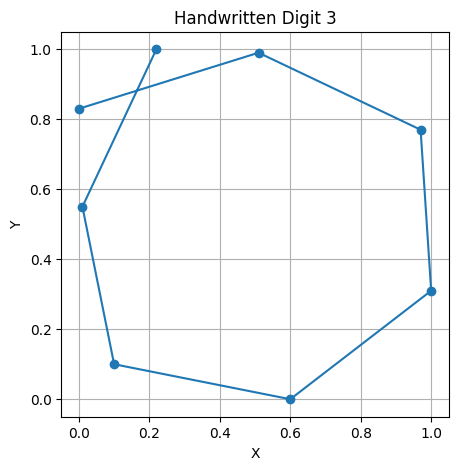

counterfactual
y = 1


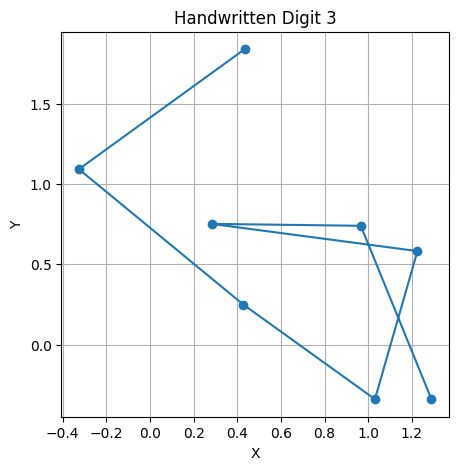

actual
y = 0


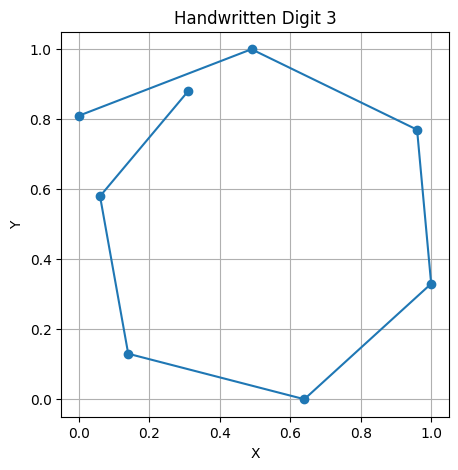

counterfactual
y = 1


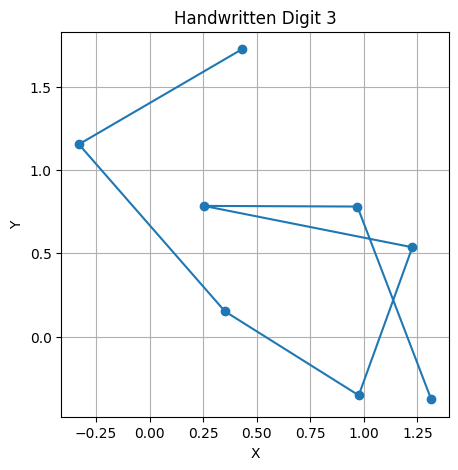

actual
y = 0


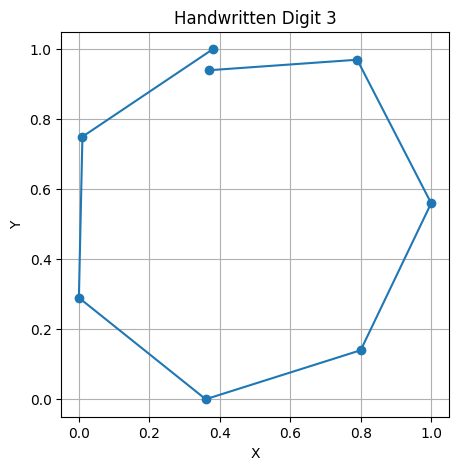

counterfactual
y = 1


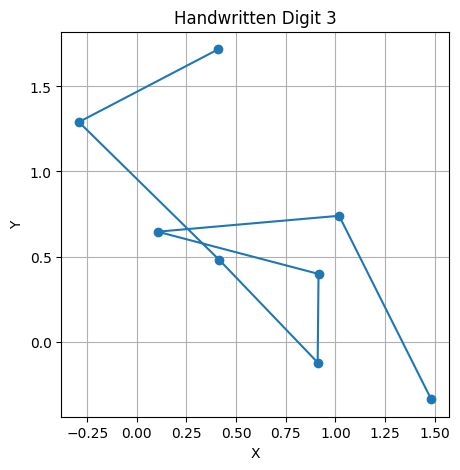

actual
y = 0


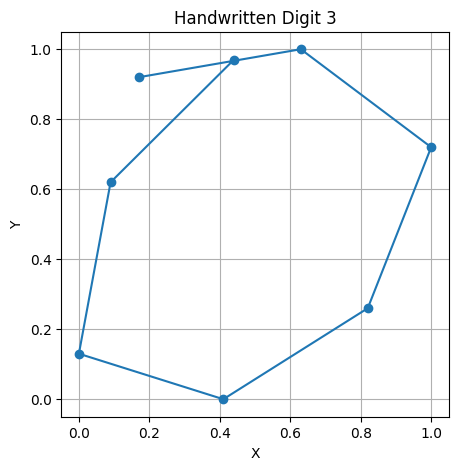

counterfactual
y = 1


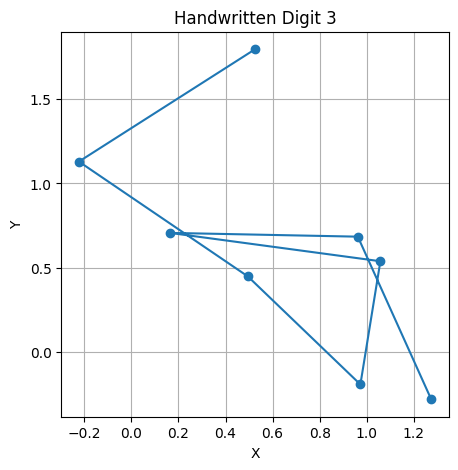

actual
y = 0


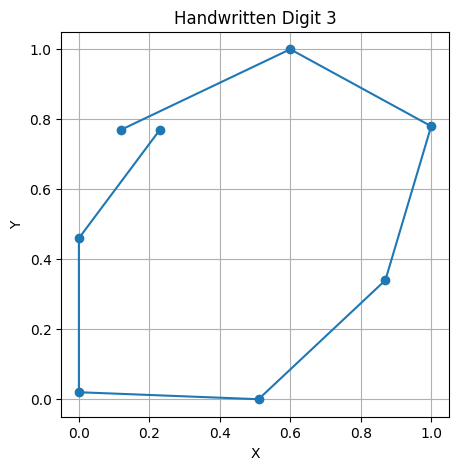

counterfactual
y = 1


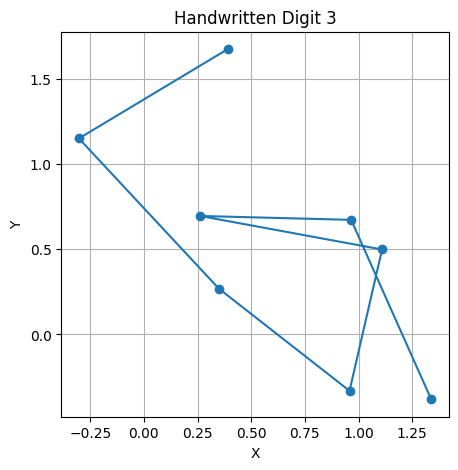

actual
y = 0


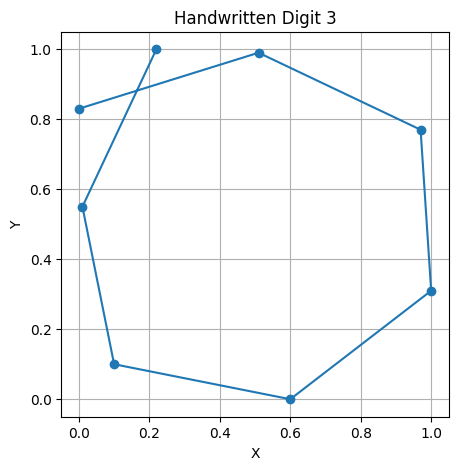

counterfactual
y = 1


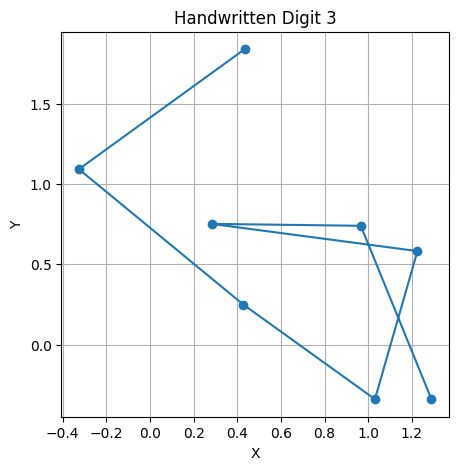

In [247]:
for i in range(6):
  print("actual")
  visualise_digit(X_neg,y_neg_classes,i-1,figsize = (5,5))
  print("counterfactual")
  visualise_digit(cf_embeddings,1-y_neg_classes,i-1,figsize = (5,5))
